# GoogLeNet

This notebook is an implement of [___Going deeper with convolutions___](https://arxiv.org/pdf/1409.4842.pdf) by Szedegy et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and thus takes less space to store on clusters and less time for training. 

We first need to install and import all the dependent libraries in the session.

In [1]:
# For pip users
# ! pip install -r ../requirements.txt
# For conda users
! conda install --file ../requirements.txt -y

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities import getCifar
from utilities import show_training_accuracy, show_Cifar_validation_result

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Solving environment: done

# All requested packages already installed.



2022-06-26 10:03:14.103782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10793 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:04:00.0, compute capability: 7.0


In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set. 

In [2]:
batch_size = 64

train, val, test = getCifar(batch_size)

2022-06-26 10:03:15.587353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10793 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:04:00.0, compute capability: 7.0


This is function that constructs a GoogLeNet model. In ```inception``` function we constructs an inception block while in ```createGoogLeNet``` function we build a fine-tuned GoogLeNet model. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. The most important change is that we only keep four inception layers because the images are very small and deep network would only cause overfitting instead of increasing performance. We define ```weight_decay``` as the hyperparameters of the model for kernel regularization.

In [6]:
def inception(input, f1, f3r, f3, f5r, f5, pp, weight_decay, output = False, output_name = None):
    x1 = Conv2D(kernel_size = 1, filters = f1, padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    
    x2 = Conv2D(kernel_size = 1, filters = f3r, padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(kernel_size = 3, filters = f3, padding = "same", kernel_regularizer = l2(weight_decay))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    
    x3 = Conv2D(kernel_size = 1, filters = f5r, padding = "same", kernel_regularizer = l2(weight_decay))(input)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3 = Conv2D(kernel_size = 5, filters = f5, padding = "same", kernel_regularizer = l2(weight_decay))(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
     
    x4 = MaxPooling2D(pool_size = 3, padding = "same", strides = 1)(input)
    x4 = Conv2D(kernel_size = 1, filters = pp, padding = "same", kernel_regularizer = l2(weight_decay))(x4)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)
    
    x5 = None
    
    if output == True:
        x5 = GlobalAveragePooling2D()(x)
        x5 = Conv2D(kernel_size = 1, padding = "same", filters = 128, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = BatchNormalization()(x5)
        x5 = Flatten()(x5)
        x5 = Dense(1024, activation = "relu", kernel_regularizer = l2(weight_decay))(x5)
        x5 = Dropout(rate = .7)(x5)
        x5 = Dense(10, activation = "softmax", name = output_name)(x5)
    
    x = Concatenate()([x1, x2, x3, x4])
    return x, x5

def createGoogLeNet(weight_decay):
    input = Input(shape = (32, 32, 3), name = "image")
#     x = Resizing(112, 112)(input)
#     x = RandomCrop(96, 96)(x)
    x = Resizing(96, 96)(input)
    x = RandomRotation(.1)(x)
    x = RandomContrast(.9)(x)
    x = RandomFlip("horizontal")(x)
    x = RandomTranslation((-.3, .3), (-.3, .3))(x)
    
    x = Conv2D(kernel_size = 7, filters = 64, strides = 2, padding = "same", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size = 3, strides = 2, padding = "same")(x)
    x = Conv2D(kernel_size = 7, filters = 96, padding = "same", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size = 3, strides = 2, padding = "same")(x)
    
    x, _ = inception(x, 64, 96, 128, 16, 32, 32, weight_decay)
    x, _ = inception(x, 128, 128, 192, 32, 96, 64, weight_decay)
    x = MaxPooling2D(pool_size = 3, padding = "same", strides = 2)(x)
    x, _ = inception(x, 192, 96, 208, 16, 48, 64, weight_decay)
    x, _ = inception(x, 160, 112, 224, 24, 64, 64, weight_decay)
    x, _ = inception(x, 128, 128, 256, 24, 64, 64, weight_decay)
    x, _ = inception(x, 112, 144, 288, 32, 64, 64, weight_decay)
    x, _ = inception(x, 256, 160, 320, 32, 128, 128, weight_decay)
    x = MaxPooling2D(pool_size = 3, padding = "same", strides = 2)(x)
    x, _ = inception(x, 256, 160, 320, 32, 128, 128, weight_decay)
    x, _ = inception(x, 384, 192, 384, 48, 128, 128, weight_decay)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    output = Dense(10, activation = "softmax", name = "out")(x)

    model = tf.keras.Model(inputs = [input], outputs = [output], name = "GoogLeNet")

    return model


This part trains the GoogLeNet model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on server so that we can continue training even if the session disconnects. We also add learning rate scheduler to slow down learning rate when validation loss stops increasing. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/150
625/625 [==============================] - 45s 60ms/step - loss: 2.6398 - accuracy: 0.3198 - val_loss: 3.1228 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 2/150
625/625 [==============================] - 36s 58ms/step - loss: 2.2131 - accuracy: 0.4193 - val_loss: 2.2517 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 3/150
625/625 [==============================] - 35s 56ms/step - loss: 1.9373 - accuracy: 0.4763 - val_loss: 2.3234 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 4/150
625/625 [==============================] - 35s 55ms/step - loss: 1.7480 - accuracy: 0.5187 - val_loss: 2.0336 - val_accuracy: 0.4134 - lr: 0.0010
Epoch 5/150
625/625 [==============================] - 35s 56ms/step - loss: 1.6070 - accuracy: 0.5526 - val_loss: 1.5862 - val_accuracy: 0.5562 - lr: 0.0010
Epoch 6/150
625/625 [==============================] - 35s 56ms/step - loss: 1.4927 - accuracy: 0.5880 - val_loss: 1.6475 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 7/150
625/625 [==============================]

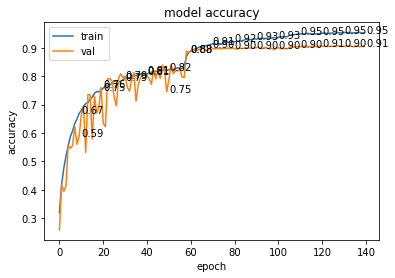

In [7]:
# Callbacks for training
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 0, 
                                        save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                                          verbose=0, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0)
es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)

# Hyperparameters
weight_decay = 1e-4
learning_rate = 1e-3

# Create GoogLeNet model
model = createGoogLeNet(weight_decay)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

history = model.fit(train, epochs = 150, validation_data = val, callbacks = [lr, es])

show_training_accuracy(history)

Here we test our model on test set and show how GoogLeNet predicts on sample images in the test set.

157/157 [==============================] - 3s 18ms/step - loss: 0.5474 - accuracy: 0.9033
Test Accuracy: 90.33%


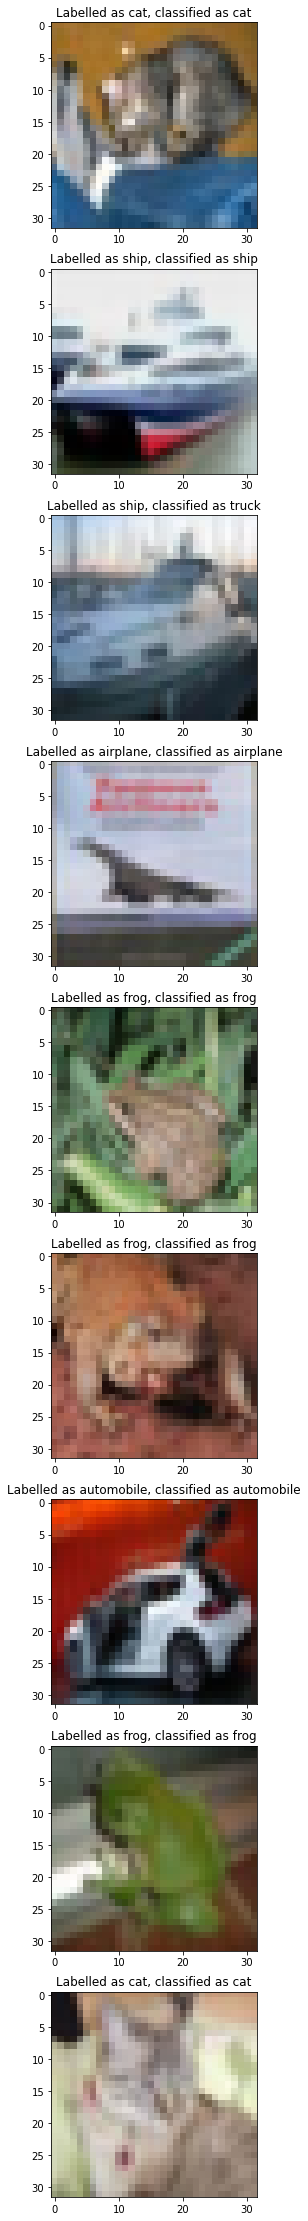

In [9]:
show_Cifar_validation_result(model, test)